In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from transformers import DistilBertModel, DistilBertTokenizer
from PIL import Image
import numpy as np
import re
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

# Data preparation
def load_data(data_dir):
    image_paths = []
    texts = []
    labels = []
    label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}

    for label_name, label_idx in label_map.items():
        folder_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(folder_path):
            continue

        # Iterate through all files in the folder
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                image_paths.append(image_path)

                # Use the filename as the text description, remove digits
                file_name_no_ext, _ = os.path.splitext(filename)
                text_description = re.sub(r'\d+', '', file_name_no_ext.replace('_', ' '))
                texts.append(text_description)

                labels.append(label_idx)

    return np.array(image_paths), np.array(texts), np.array(labels)

# Load data
train_dir = '../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Train'
val_dir = '../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Val'
test_dir = '../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test'

train_image_paths, train_texts, train_labels = load_data(train_dir)
val_image_paths, val_texts, val_labels = load_data(val_dir)
test_image_paths, test_texts, test_labels = load_data(test_dir)

# Define the custom dataset
class MultimodalDataset(Dataset):
    def __init__(self, image_paths, texts, labels, transform=None, tokenizer=None, max_len=24):
        self.image_paths = image_paths
        self.texts = texts
        self.labels = labels
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize text
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        label = self.labels[idx]

        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets and dataloaders
train_dataset = MultimodalDataset(train_image_paths, train_texts, train_labels, transform=transform, tokenizer=tokenizer)
val_dataset = MultimodalDataset(val_image_paths, val_texts, val_labels, transform=transform, tokenizer=tokenizer)
test_dataset = MultimodalDataset(test_image_paths, test_texts, test_labels, transform=transform, tokenizer=tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Multimodal model combining ResNet50 and DistilBERT
class MultimodalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalModel, self).__init__()
        # Load pretrained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.resnet_feature_dim = 2048

        # Load DistilBERT model
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.distilbert_feature_dim = 768

        # Fully connected layers for combining features
        self.fc = nn.Sequential(
            nn.Linear(self.resnet_feature_dim + self.distilbert_feature_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
            

    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = self.resnet(images)
        # Extract text features
        text_features = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Pass through fully connected layers
        output = self.fc(combined_features)
        return output

# Hyperparameters and model setup
num_classes = 4
learning_rate = 2e-5
num_epochs = 10


# Label map
label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}

# Count the number of files in each class directory
class_counts = np.zeros(len(label_map), dtype=np.int32)
for label_name, label_idx in label_map.items():
    folder_path = os.path.join(train_dir, label_name)
    if os.path.isdir(folder_path):
        class_counts[label_idx] = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Calculate the class weights using inverse frequency
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Print the class counts and weights
for class_name, count, weight in zip(label_map.keys(), class_counts, class_weights):
    print(f'Class {class_name}: {count} samples, Weight: {weight:.4f}')


model = MultimodalModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training with early stopping
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0



Using device: mps
Class Black: 2111 samples, Weight: 0.2662
Class Blue: 4355 samples, Weight: 0.1291
Class Green: 1991 samples, Weight: 0.2823
Class TTR: 1743 samples, Weight: 0.3224


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(y_true, y_pred)
    val_precision = precision_score(y_true, y_pred, average='weighted')
    val_recall = recall_score(y_true, y_pred, average='weighted')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val Prec: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

    scheduler.step()

    # Check for early stopping
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_multimodal_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break



In [8]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_multimodal_model.pth', map_location=torch.device('mps')))
model.eval()
test_predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        test_predictions.extend(preds.cpu().numpy())


/var/folders/_m/p9lrk0vj7l9dgy03bgtt6sm80000gn/T/ipykernel_42638/1751341563.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_multim

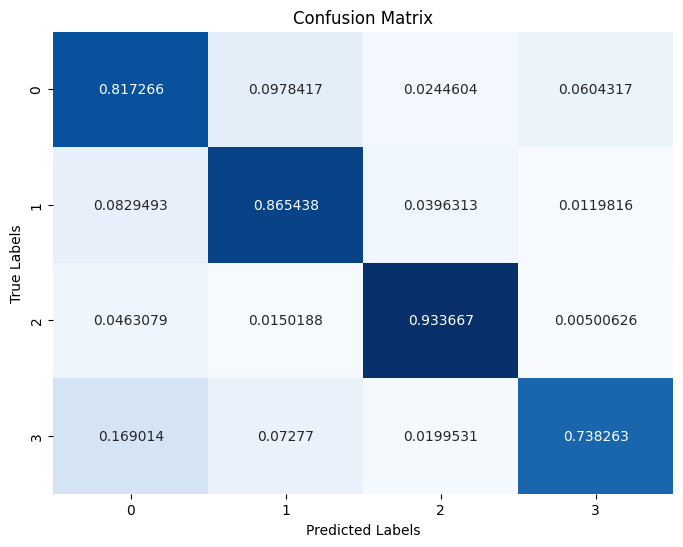

Test Accuracy: 0.8400, Test Precision: 0.8499, Test Recall: 0.8400
Accuracy for Black: 0.8173
Accuracy for Blue: 0.8654
Accuracy for Green: 0.9337
Accuracy for TTR: 0.7383


In [9]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Test set metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='weighted')
test_recall = recall_score(test_labels, test_predictions, average='weighted')
print(f'Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

# Calculate the accuracy for each class
class_accuracy = cm.diagonal() / cm.sum(axis=1)

label_map = {"Black": 0, "Blue": 1, "Green": 2, "TTR": 3}
# Map label indices back to class names
label_names = {v: k for k, v in label_map.items()}

# Print accuracy per class
for i, accuracy in enumerate(class_accuracy):
    class_name = label_names[i]
    print(f'Accuracy for {class_name}: {accuracy:.4f}')


Number of cases where "Other" was mistakenly identified as "Blue": 65
Indices of the mistakes: [2602, 2608, 2620, 2631, 2633, 2671, 2701, 2717, 2731, 2738, 2763, 2766, 2771, 2797, 2798, 2802, 2808, 2820, 2829, 2830, 2859, 2869, 2876, 2883, 2889, 2899, 2913, 2917, 2919, 2921, 2942, 2959, 2989, 3025, 3052, 3076, 3079, 3093, 3095, 3096, 3100, 3124, 3142, 3148, 3163, 3169, 3172, 3180, 3215, 3281, 3303, 3316, 3322, 3340, 3347, 3349, 3360, 3361, 3371, 3372, 3375, 3378, 3387, 3403, 3418]
['../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test/TTR/partially_burned_yellow_candle_in_jar_2872.png'
 '../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test/TTR/closed_tool_box_3107.png'
 '../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test/TTR/drano_container_1430.png'
 '../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test/TTR/air_freshner_bottle_104.png'
 '../../data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test/TTR/Vinyl_Record_673.png'
 '../../data/enel645_2024f/g

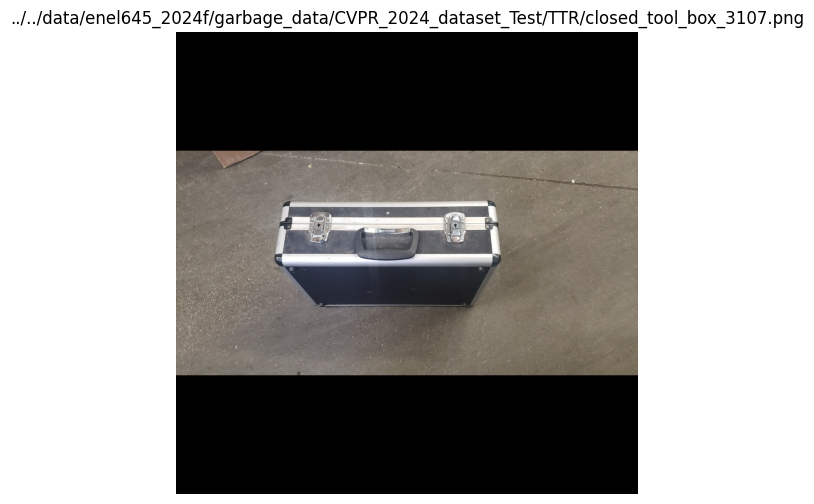

In [7]:
mistaken_indices = [i for i, (true, pred) in enumerate(zip(test_labels, test_predictions)) if true == 3 and pred == 1]
print(f'Number of cases where "Other" was mistakenly identified as "Blue": {len(mistaken_indices)}')
print("Indices of the mistakes:", mistaken_indices)

# keywords: plastic, bottle, Container, box, packaging, bag, wrapper
# Load the image
print(test_image_paths[mistaken_indices])

image_path = test_image_paths[mistaken_indices[1]]

image = Image.open(image_path)

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.title(image_path)
plt.show()
